<a href="https://colab.research.google.com/github/a-0yahya/Portfolio_A.Y/blob/main/Distilbert_full_ABSA_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This code is using full distilbert-base-uncased and the data is unbalanced and using Preprocessing data vs raw data and usign to  save it based on the best validation F1 score

1. Data Loading and Splitting



In [ ]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split

# Load dataset from file (ensure "dataset.csv" is available)
df = pd.read_csv("dataset.csv")

# Print available columns for verification
print("Dataset columns:", df.columns.tolist())

# Remove duplicate columns if any
df = df.loc[:, ~df.columns.duplicated()]

# Convert the sentiment column to numeric (your dataset already uses 0, 1, 2)
df["sentiment"] = pd.to_numeric(df["sentiment"], errors='coerce')
print("Unique sentiment values (original):", df["sentiment"].unique())

# Split the data using stratification on the sentiment column
train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df["sentiment"], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df["sentiment"], random_state=42)

# Copy sentiment column to a new column 'sentiment_id'
train_df["sentiment_id"] = train_df["sentiment"]
val_df["sentiment_id"] = val_df["sentiment"]
test_df["sentiment_id"] = test_df["sentiment"]

# Remove any duplicate columns that might appear after splitting
train_df = train_df.loc[:, ~train_df.columns.duplicated()]
val_df = val_df.loc[:, ~val_df.columns.duplicated()]
test_df = test_df.loc[:, ~test_df.columns.duplicated()]

print("Train shape:", train_df.shape)
print("Validation shape:", val_df.shape)
print("Test shape:", test_df.shape)
print("Unique sentiment IDs in train:", train_df["sentiment_id"].unique())


Dataset columns: ['Reviews', 'sentiment', 'BATTERY', 'PERFORMANCE', 'CAMERA', 'DISPLAY', 'PRICE', 'MULTIMEDIA', 'FITNESS & HEALTH TRACKING', 'CUSTOMIZATION']
Unique sentiment values (original): [1 2 0]
Train shape: (1799, 11)
Validation shape: (225, 11)
Test shape: (225, 11)
Unique sentiment IDs in train: [2 0 1]


2. Data Preprocessing and Encoding

In [ ]:
# Define the aspect columns (assumed numeric: 0/1)
aspect_columns = ["BATTERY", "PERFORMANCE", "CAMERA", "DISPLAY", "PRICE", "MULTIMEDIA", "FITNESS & HEALTH TRACKING", "CUSTOMIZATION"]

# Create a new column 'aspect_vector' by collecting values from the aspect columns
train_df["aspect_vector"] = train_df[aspect_columns].values.tolist()
val_df["aspect_vector"] = val_df[aspect_columns].values.tolist()
test_df["aspect_vector"] = test_df[aspect_columns].values.tolist()

print("First few aspect vectors in train:")
print(train_df["aspect_vector"].head())

# Create a dictionary mapping starting from 1
aspect_dict = {i+1: aspect for i, aspect in enumerate(aspect_columns)}

# Print out the mapping in a readable format.
for idx, name in aspect_dict.items():
    print(f"Aspect {idx} means {name}")


First few aspect vectors in train:
239     [0, 1, 0, 1, 0, 0, 0, 0]
821     [1, 0, 0, 0, 0, 0, 1, 0]
1272    [0, 0, 0, 0, 1, 0, 0, 1]
424     [0, 0, 0, 0, 0, 0, 0, 0]
96      [1, 0, 0, 0, 0, 0, 0, 0]
Name: aspect_vector, dtype: object
Aspect 1 means BATTERY
Aspect 2 means PERFORMANCE
Aspect 3 means CAMERA
Aspect 4 means DISPLAY
Aspect 5 means PRICE
Aspect 6 means MULTIMEDIA
Aspect 7 means FITNESS & HEALTH TRACKING
Aspect 8 means CUSTOMIZATION


3. Tokenization and Dataset Creation


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer

# Initialize the DistilBERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize_batch(text_list):
    return tokenizer(text_list, padding="max_length", truncation=True, max_length=128, return_tensors="pt")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
class ReviewsDataset(Dataset):
    def __init__(self, dataframe):
        # Convert reviews to strings and replace missing values with an empty string.
        # Change "Reviews" to "review" if needed.
        self.texts = list(dataframe["Reviews"].fillna("").astype(str))
        self.sentiments = list(dataframe["sentiment_id"].astype(int))
        self.aspects = dataframe["aspect_vector"].tolist()
        encodings = tokenize_batch(self.texts)
        self.input_ids = encodings["input_ids"]
        self.attn_masks = encodings["attention_mask"]

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return {
            "input_ids": self.input_ids[idx],
            "attention_mask": self.attn_masks[idx],
            "sentiment": torch.tensor(self.sentiments[idx], dtype=torch.long),
            "aspects": torch.tensor(self.aspects[idx], dtype=torch.float)
        }

train_dataset = ReviewsDataset(train_df)
val_dataset   = ReviewsDataset(val_df)
test_dataset  = ReviewsDataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=16, shuffle=False)

print("Data processing complete. Number of training samples:", len(train_dataset))


Data processing complete. Number of training samples: 1799


4. Model Definition


In [ ]:
import torch.nn as nn
from transformers import DistilBertModel
import torch

class DistilBertForMultiOutputImproved(nn.Module):
    def __init__(self, pretrained_model_name="distilbert-base-uncased",
                 num_sentiment_labels=3, num_aspect_labels=8,
                 dropout_rate=0.6, sentiment_class_weights=None):
        super(DistilBertForMultiOutputImproved, self).__init__()
        self.distilbert = DistilBertModel.from_pretrained(pretrained_model_name)
        hidden_size = self.distilbert.config.hidden_size
        self.dropout = nn.Dropout(dropout_rate)
        self.sentiment_classifier = nn.Linear(hidden_size, num_sentiment_labels)
        self.aspect_classifier = nn.Linear(hidden_size, num_aspect_labels)
        self.sentiment_class_weights = sentiment_class_weights

    def forward(self, input_ids, attention_mask=None, labels=None):
        outputs = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        cls_hidden_state = outputs.last_hidden_state[:, 0]
        cls_hidden_state = self.dropout(cls_hidden_state)

        sentiment_logits = self.sentiment_classifier(cls_hidden_state)
        aspect_logits = self.aspect_classifier(cls_hidden_state)

        loss = None
        if labels is not None:
            # Use weighted loss if class weights are provided
            if self.sentiment_class_weights is not None:
                weights = torch.tensor(self.sentiment_class_weights).to(sentiment_logits.device)
                loss_sentiment = nn.CrossEntropyLoss(weight=weights)(sentiment_logits, labels["sentiment"])
            else:
                loss_sentiment = nn.CrossEntropyLoss()(sentiment_logits, labels["sentiment"])
            loss_aspects = nn.BCEWithLogitsLoss()(aspect_logits, labels["aspects"].type_as(aspect_logits))
            loss = loss_sentiment + loss_aspects

        return {"loss": loss, "sentiment_logits": sentiment_logits, "aspect_logits": aspect_logits}


5. Training and Evaluation


In [ ]:
import torch
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import numpy as np

In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate the improved model
model = DistilBertForMultiOutputImproved(sentiment_class_weights=None)
model.to(device)

# Use PyTorch's AdamW with weight decay for regularization
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-6, weight_decay=0.05)
num_epochs = 30
total_steps = len(train_loader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=int(0.1 * total_steps), num_training_steps=total_steps)

In [ ]:
# Dictionary to store training history for visualization
report = {
    "epoch": [],
    "train_loss": [],
    "val_loss": [],
    "train_acc": [],
    "val_acc": [],
    "val_f1": [],
    "val_recall": [],
    "val_precision": []
}

best_f1_score = 0.0  # Track the best validation F1 score
best_model_state = None  # Store the best model state
patience = 6
epochs_no_improve = 0

for epoch in range(1, num_epochs + 1):
    model.train()
    train_loss = 0.0
    train_preds, train_labels = [], []

    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        sent_labels = batch["sentiment"].to(device)
        aspect_labels = batch["aspects"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask,
                        labels={"sentiment": sent_labels, "aspects": aspect_labels})

        loss = outputs["loss"]
        loss.backward()
        optimizer.step()
        scheduler.step()

        train_loss += loss.item()
        preds = outputs["sentiment_logits"].argmax(dim=1).cpu().numpy()
        train_preds.extend(preds.tolist())
        train_labels.extend(sent_labels.cpu().numpy().tolist())

    avg_train_loss = train_loss / len(train_loader)
    train_acc = accuracy_score(train_labels, train_preds)

    model.eval()
    val_loss = 0.0
    all_sent_preds, all_sent_labels = [], []

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            sent_labels = batch["sentiment"].to(device)
            aspect_labels = batch["aspects"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask,
                            labels={"sentiment": sent_labels, "aspects": aspect_labels})

            val_loss += outputs["loss"].item()
            sent_preds = outputs["sentiment_logits"].argmax(dim=1).cpu().numpy()
            all_sent_preds.extend(sent_preds.tolist())
            all_sent_labels.extend(sent_labels.cpu().numpy().tolist())

    avg_val_loss = val_loss / len(val_loader)
    val_acc = accuracy_score(all_sent_preds, all_sent_labels)
    val_f1 = f1_score(all_sent_preds, all_sent_labels, average="macro")
    val_recall = recall_score(all_sent_preds, all_sent_labels, average="macro")
    val_precision = precision_score(all_sent_preds, all_sent_labels, average="macro", zero_division=0)

    print(f"Epoch {epoch}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
    print(f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f} | Val Recall: {val_recall:.4f} | Val Precision: {val_precision:.4f}")

    report["epoch"].append(epoch)
    report["train_loss"].append(avg_train_loss)
    report["val_loss"].append(avg_val_loss)
    report["train_acc"].append(train_acc)
    report["val_acc"].append(val_acc)
    report["val_f1"].append(val_f1)
    report["val_recall"].append(val_recall)
    report["val_precision"].append(val_precision)

    # Track the best model based on highest validation F1 score
    if val_f1 > best_f1_score:
        best_f1_score = val_f1
        best_model_state = model.state_dict()  # Save the best model state
        epochs_no_improve = 0  # Reset early stopping counter
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered.")
            break

# Save the best model at the end
if best_model_state:
    torch.save(best_model_state, "best_model_f1.pth")
    print("Best model (based on validation F1 score) saved at the end of training.")


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/30 | Train Loss: 1.8518 | Val Loss: 1.7280
Train Acc: 0.2941 | Val Acc: 0.4756 | Val F1: 0.3404 | Val Recall: 0.3226 | Val Precision: 0.3770


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 2/30 | Train Loss: 1.6932 | Val Loss: 1.5859
Train Acc: 0.4541 | Val Acc: 0.7244 | Val F1: 0.5251 | Val Recall: 0.4846 | Val Precision: 0.5751


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 3/30 | Train Loss: 1.4945 | Val Loss: 1.1928
Train Acc: 0.6253 | Val Acc: 0.7733 | Val F1: 0.5603 | Val Recall: 0.5157 | Val Precision: 0.6137
Epoch 4/30 | Train Loss: 1.1745 | Val Loss: 1.0298
Train Acc: 0.7588 | Val Acc: 0.8000 | Val F1: 0.6258 | Val Recall: 0.7364 | Val Precision: 0.6521
Epoch 5/30 | Train Loss: 1.0296 | Val Loss: 1.0022
Train Acc: 0.8099 | Val Acc: 0.7911 | Val F1: 0.6195 | Val Recall: 0.6994 | Val Precision: 0.6450
Epoch 6/30 | Train Loss: 0.9203 | Val Loss: 0.9881
Train Acc: 0.8527 | Val Acc: 0.7956 | Val F1: 0.7060 | Val Recall: 0.7306 | Val Precision: 0.7001
Epoch 7/30 | Train Loss: 0.8274 | Val Loss: 1.0157
Train Acc: 0.8933 | Val Acc: 0.7956 | Val F1: 0.7064 | Val Recall: 0.7327 | Val Precision: 0.7001
Epoch 8/30 | Train Loss: 0.7563 | Val Loss: 1.0168
Train Acc: 0.9094 | Val Acc: 0.8000 | Val F1: 0.7029 | Val Recall: 0.7332 | Val Precision: 0.6979
Epoch 9/30 | Train Loss: 0.6962 | Val Loss: 1.0134
Train Acc: 0.9383 | Val Acc: 0.8089 | Val F1: 0.7300 | 

In [ ]:

# Load the best model for evaluation
print("Loading best model (based on validation F1 score) for final testing...")
model.load_state_dict(torch.load("best_model_f1.pth"))
model.eval()


Loading best model (based on validation F1 score) for final testing...


<ipython-input-24-2de01093d2b9>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model_f1.pth"))


DistilBertForMultiOutputImproved(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
   

6. Visualization of Training/Validation Metrics

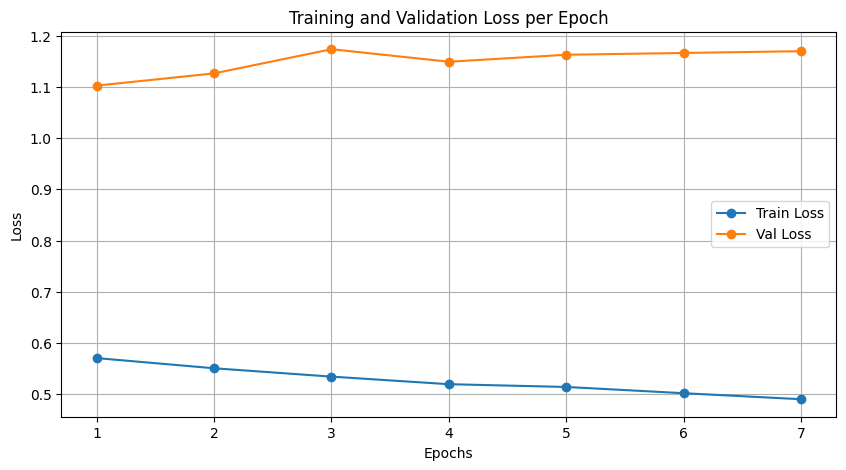

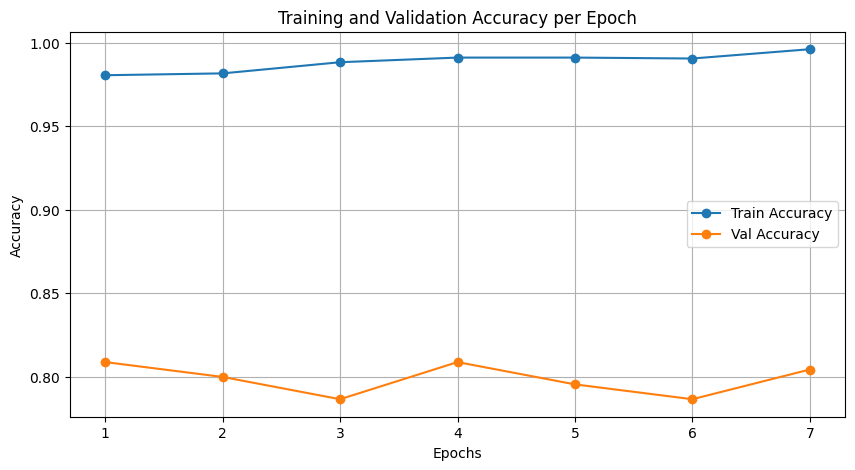

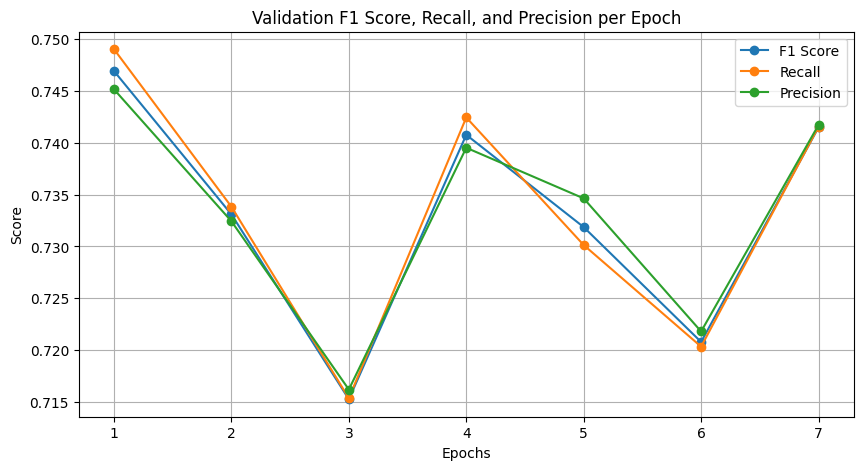

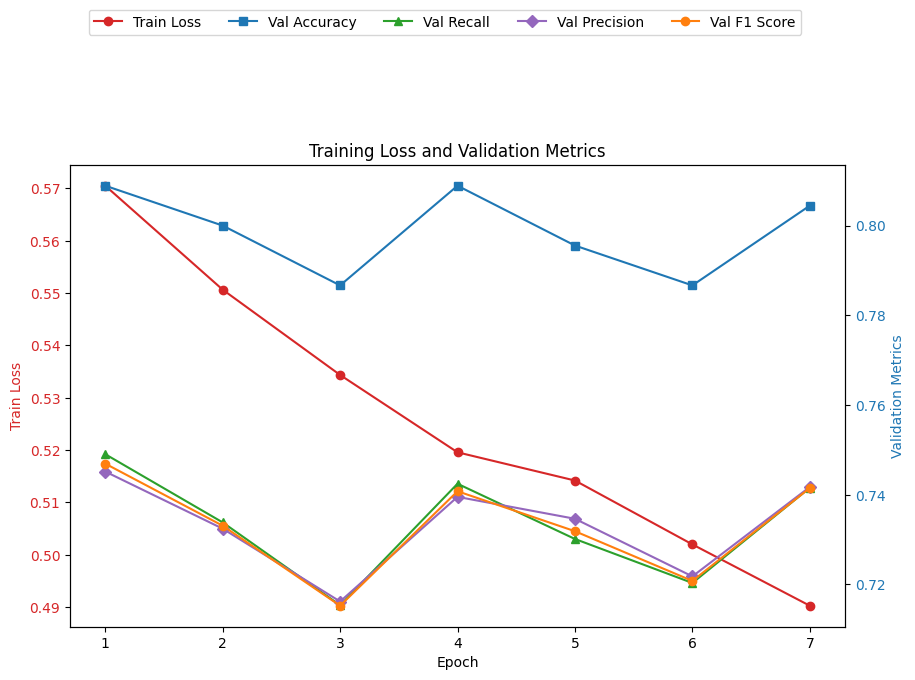

╒════════════════════════╤═════════╕
│ Metric                 │   Value │
╞════════════════════════╪═════════╡
│ Test Loss              │  1.4222 │
├────────────────────────┼─────────┤
│ Test Accuracy          │  0.8    │
├────────────────────────┼─────────┤
│ Test F1 Score (Macro)  │  0.7316 │
├────────────────────────┼─────────┤
│ Test Recall (Macro)    │  0.7323 │
├────────────────────────┼─────────┤
│ Test Precision (Macro) │  0.7323 │
╘════════════════════════╧═════════╛


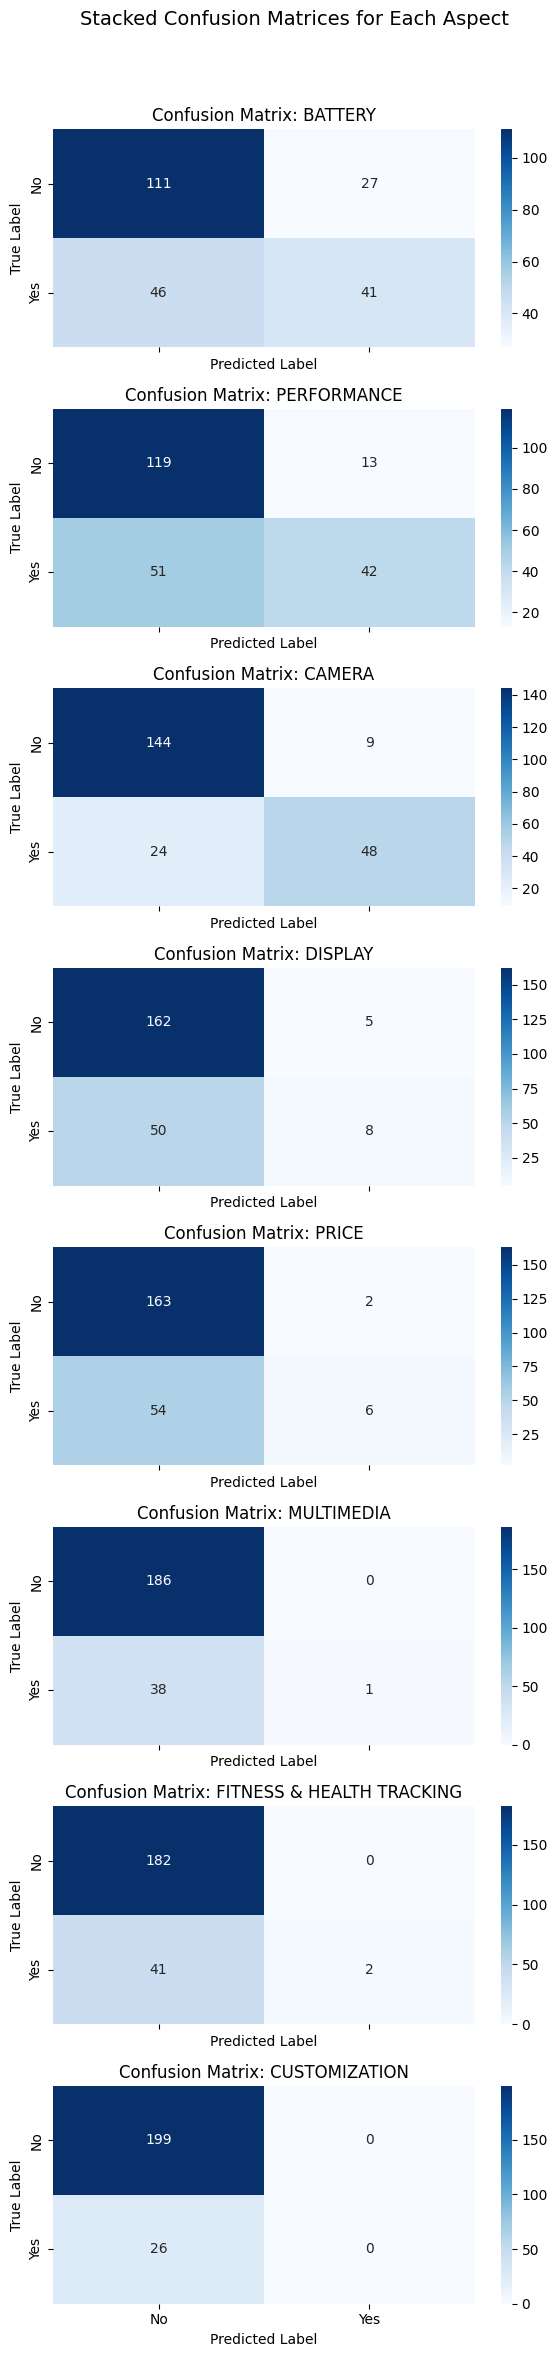

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

report_df = pd.DataFrame(report)

# 1. Training and Validation Loss Plot
plt.figure(figsize=(10, 5))
plt.plot(report_df['epoch'], report_df['train_loss'], label="Train Loss", marker='o')
plt.plot(report_df['epoch'], report_df['val_loss'], label="Val Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss per Epoch")
plt.legend()
plt.grid(True)
plt.show()

# 2. Training and Validation Accuracy Plot
plt.figure(figsize=(10, 5))
plt.plot(report_df['epoch'], report_df['train_acc'], label="Train Accuracy", marker='o')
plt.plot(report_df['epoch'], report_df['val_acc'], label="Val Accuracy", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy per Epoch")
plt.legend()
plt.grid(True)
plt.show()

# 3. Validation F1 Score, Recall, and Precision Plot
plt.figure(figsize=(10, 5))
plt.plot(report_df['epoch'], report_df['val_f1'], label="F1 Score", marker='o')
plt.plot(report_df['epoch'], report_df['val_recall'], label="Recall", marker='o')
plt.plot(report_df['epoch'], report_df['val_precision'], label="Precision", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Score")
plt.title("Validation F1 Score, Recall, and Precision per Epoch")
plt.legend()
plt.grid(True)
plt.show()

# 4. Combined Plot of Training Loss and Validation Metrics
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Train Loss', color='tab:red')
ax1.plot(report_df['epoch'], report_df['train_loss'], 'o-', color='tab:red', label='Train Loss')
ax1.tick_params(axis='y', labelcolor='tab:red')
ax2 = ax1.twinx()
ax2.set_ylabel('Validation Metrics', color='tab:blue')
ax2.plot(report_df['epoch'], report_df['val_acc'], 's-', color='tab:blue', label='Val Accuracy')
ax2.plot(report_df['epoch'], report_df['val_recall'], '^-', color='tab:green', label='Val Recall')
ax2.plot(report_df['epoch'], report_df['val_precision'], 'D-', color='tab:purple', label='Val Precision')
ax2.plot(report_df['epoch'], report_df['val_f1'], 'o-', color='tab:orange', label='Val F1 Score')
ax2.tick_params(axis='y', labelcolor='tab:blue')
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=5)
plt.title('Training Loss and Validation Metrics')
plt.show()

# 5. Tabular Display of Test Metrics
def evaluate_test(loader):
    model.eval()
    test_loss = 0.0
    all_sent_preds, all_sent_labels = [], []
    all_aspect_preds, all_aspect_labels = [], []
    with torch.no_grad():
        for batch in loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            sent_labels = batch["sentiment"].to(device)
            aspect_labels = batch["aspects"].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask,
                            labels={"sentiment": sent_labels, "aspects": aspect_labels})
            test_loss += outputs["loss"].item()
            sent_preds = outputs["sentiment_logits"].argmax(dim=1).cpu().numpy()
            aspect_preds = (torch.sigmoid(outputs["aspect_logits"]) >= 0.5).cpu().numpy()
            all_sent_preds.extend(sent_preds.tolist())
            all_sent_labels.extend(sent_labels.cpu().numpy().tolist())
            all_aspect_preds.extend(aspect_preds.tolist())
            all_aspect_labels.extend(aspect_labels.cpu().numpy().tolist())
    avg_loss = test_loss / len(loader)
    test_acc = accuracy_score(all_sent_labels, all_sent_preds)
    test_f1 = f1_score(all_sent_labels, all_sent_preds, average="macro")
    test_recall = recall_score(all_sent_labels, all_sent_preds, average="macro")
    test_precision = precision_score(all_sent_labels, all_sent_preds, average="macro", zero_division=0)
    return avg_loss, test_acc, test_f1, test_recall, test_precision, np.array(all_aspect_labels), np.array(all_aspect_preds)

test_loss, test_acc, test_f1, test_recall, test_precision, aspect_true, aspect_pred = evaluate_test(test_loader)

results_table = [
    ["Test Loss", round(test_loss, 4)],
    ["Test Accuracy", round(test_acc, 4)],
    ["Test F1 Score (Macro)", round(test_f1, 4)],
    ["Test Recall (Macro)", round(test_recall, 4)],
    ["Test Precision (Macro)", round(test_precision, 4)]
]
print(tabulate(results_table, headers=["Metric", "Value"], tablefmt="fancy_grid"))

# 6. Stacked Confusion Matrices for Multi-Label Classification (Aspects)
from sklearn.metrics import confusion_matrix

num_aspects = len(aspect_columns)
fig, axes = plt.subplots(num_aspects, 1, figsize=(6, num_aspects * 3), sharex=True, sharey=True)
fig.suptitle("Stacked Confusion Matrices for Each Aspect", fontsize=14)
for i, aspect in enumerate(aspect_columns):
    cm = confusion_matrix(aspect_true[:, i], aspect_pred[:, i])
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=True, ax=axes[i])
    axes[i].set_title(f"Confusion Matrix: {aspect}")
    axes[i].set_xlabel("Predicted Label")
    axes[i].set_ylabel("True Label")
    axes[i].set_xticklabels(["No", "Yes"])
    axes[i].set_yticklabels(["No", "Yes"])
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


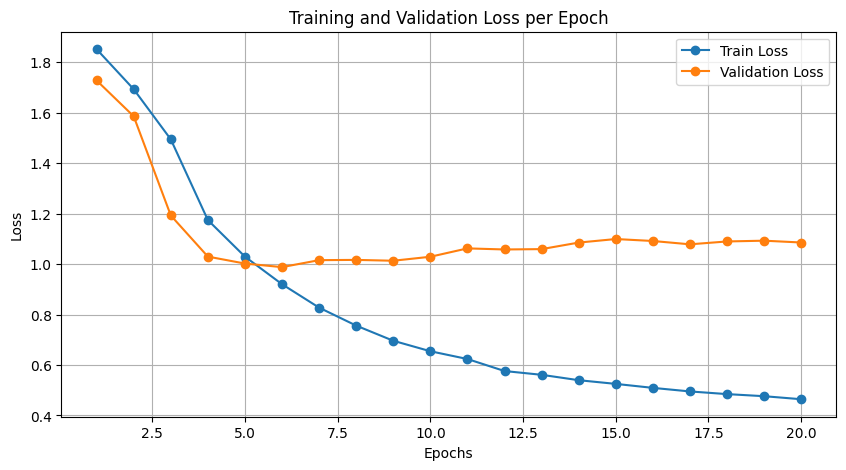

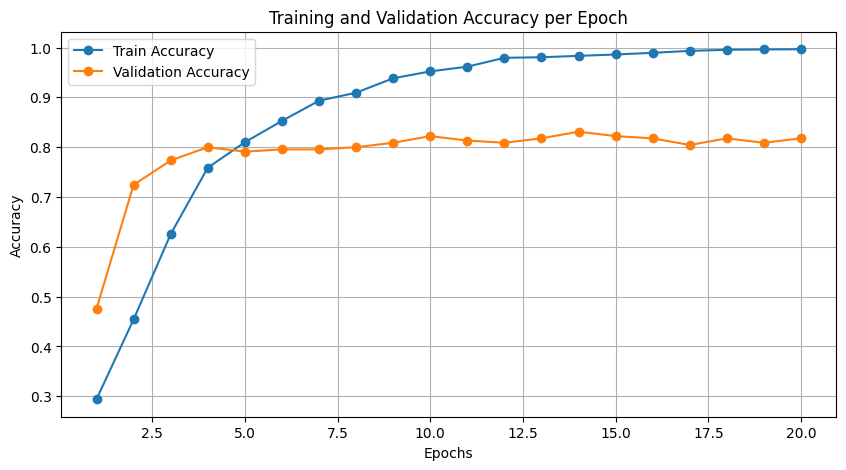

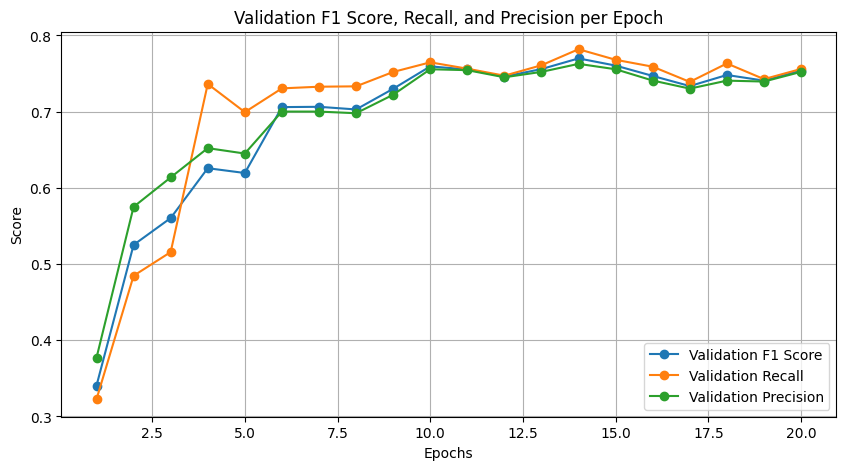

In [ ]:
import matplotlib.pyplot as plt

# Convert report dictionary to NumPy arrays for easier plotting
epochs = np.array(report["epoch"])
train_loss = np.array(report["train_loss"])
val_loss = np.array(report["val_loss"])
train_acc = np.array(report["train_acc"])
val_acc = np.array(report["val_acc"])
val_f1 = np.array(report["val_f1"])
val_recall = np.array(report["val_recall"])
val_precision = np.array(report["val_precision"])

# Create and save training/validation loss plot
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, label="Train Loss", marker='o')
plt.plot(epochs, val_loss, label="Validation Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss per Epoch")
plt.legend()
plt.grid(True)
plt.savefig("training_validation_loss.png")  # Save plot
plt.show()

# Create and save training/validation accuracy plot
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_acc, label="Train Accuracy", marker='o')
plt.plot(epochs, val_acc, label="Validation Accuracy", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy per Epoch")
plt.legend()
plt.grid(True)
plt.savefig("training_validation_accuracy.png")  # Save plot
plt.show()

# Create and save validation F1, Recall, Precision plot
plt.figure(figsize=(10, 5))
plt.plot(epochs, val_f1, label="Validation F1 Score", marker='o')
plt.plot(epochs, val_recall, label="Validation Recall", marker='o')
plt.plot(epochs, val_precision, label="Validation Precision", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Score")
plt.title("Validation F1 Score, Recall, and Precision per Epoch")
plt.legend()
plt.grid(True)
plt.savefig("validation_f1_recall_precision.png")  # Save plot
plt.show()


6. Saving and Loading the Model


In [ ]:
# To load the saved model later:
model.load_state_dict(torch.load("best_model_f1.pth"))
model.to(device)
model.eval()

from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

<ipython-input-26-d92fe24dc110>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model_f1.pth"))


7. Inference on New Reviews

In [ ]:
def predict_reviews(reviews):
    encodings = tokenizer(reviews, padding="max_length", truncation=True, max_length=128, return_tensors="pt")
    input_ids = encodings["input_ids"].to(device)
    attention_mask = encodings["attention_mask"].to(device)
    model.eval()
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    sentiment_logits = outputs["sentiment_logits"]
    aspect_logits = outputs["aspect_logits"]
    sentiment_preds = sentiment_logits.argmax(dim=1).cpu().numpy()
    aspect_probs = torch.sigmoid(aspect_logits).cpu().numpy()
    aspect_preds = (aspect_probs >= 0.5).astype(int)
    id_to_sentiment = {0: "Negative", 1: "Positive", 2: "Neutral"}
    predicted_sentiments = [id_to_sentiment.get(idx, "Unknown") for idx in sentiment_preds]
    predicted_aspects = []
    for vec in aspect_preds:
        present_aspects = [aspect for aspect, flag in zip(aspect_columns, vec) if flag == 1]
        predicted_aspects.append(present_aspects)
    for review, sent, aspects in zip(reviews, predicted_sentiments, predicted_aspects):
        print("\nReview:", review)
        print("Predicted Sentiment:", sent)
        print("Predicted Aspects:", aspects if aspects else "None")

# Example inference
sample_reviews = [
    "The battery life is amazing, and the camera quality is superb.",
    "Poor performance and a disappointing display. Not worth the price.",
    "A used / renewed phone is hardly going to be perfect. Here is how my phone came. Battery: 100% (7 cycles) Screen: Not perfect; some minor scratches! Not worth sending back (certainly usable) but noticeable with a keen eye and the right angle. Back glass: Perfect. Camera glass: Perfect. Accessories in the box: my phone came with a no-name charger and cable, a silicone case, and a pre-applied screen protector. Functionality: works as expected. The iPhone transfer process is very seamless. P.S. FYI, for MS residents, T-Mobile / Mint is way better than Verizon / Visible; I was getting 2-3Mbps (download) on Visible but 130Mbps on Mint!"
]
predict_reviews(sample_reviews)



Review: The battery life is amazing, and the camera quality is superb.
Predicted Sentiment: Positive
Predicted Aspects: None

Review: Poor performance and a disappointing display. Not worth the price.
Predicted Sentiment: Negative
Predicted Aspects: None

Review: A used / renewed phone is hardly going to be perfect. Here is how my phone came. Battery: 100% (7 cycles) Screen: Not perfect; some minor scratches! Not worth sending back (certainly usable) but noticeable with a keen eye and the right angle. Back glass: Perfect. Camera glass: Perfect. Accessories in the box: my phone came with a no-name charger and cable, a silicone case, and a pre-applied screen protector. Functionality: works as expected. The iPhone transfer process is very seamless. P.S. FYI, for MS residents, T-Mobile / Mint is way better than Verizon / Visible; I was getting 2-3Mbps (download) on Visible but 130Mbps on Mint!
Predicted Sentiment: Neutral
Predicted Aspects: ['BATTERY', 'PERFORMANCE', 'DISPLAY']
